# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 
***
In this project, you will write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. The camera calibration images, test road images, and project videos are available in the project repository or in the repository folder included with the workspace. This algorithm will then be applied to the test video "project_video.mp4". 


In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools we have in addition to the previous techniques used in Prokect 1 are camera calibration, persepctive transform, color gradient thresholding, and distortion correction, and defining margins for easier detection based on histogram anaysis.  You are also free to explore and try other techniques that were not presented in the lesson.  The project objectives go as follows: 

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

<figure>
 <img src="examples/warped_straight_lines.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting the lanes using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/example_output.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to calculate the lane curvature given the starting points from the color gradient peaks and highlight the lane region within those fitted lines as shown.</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

### Import Packages

In [1]:
#importing some useful packages
# import workspace_utils.py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from PIL import Image
from ipywidgets import interact, interactive, fixed
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


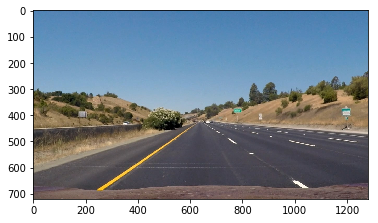

In [2]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

### Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

### Importing Test Media

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
INPUT_FOLDER = "./input/"
OUTPUT_FOLDER = "./output/"
TEST_IMAGE = "test_image.jpg"
TEST_VIDEO = "test_video.mov"


In [4]:
import os
imgListing = os.listdir("test_images/")
print(*imgListing, sep = "\n")


straight_lines1.jpg
test2.jpg
straight_lines2.jpg
test4.jpg
test1.jpg
test6.jpg
test5.jpg
test3.jpg


### Display Images Helper Function

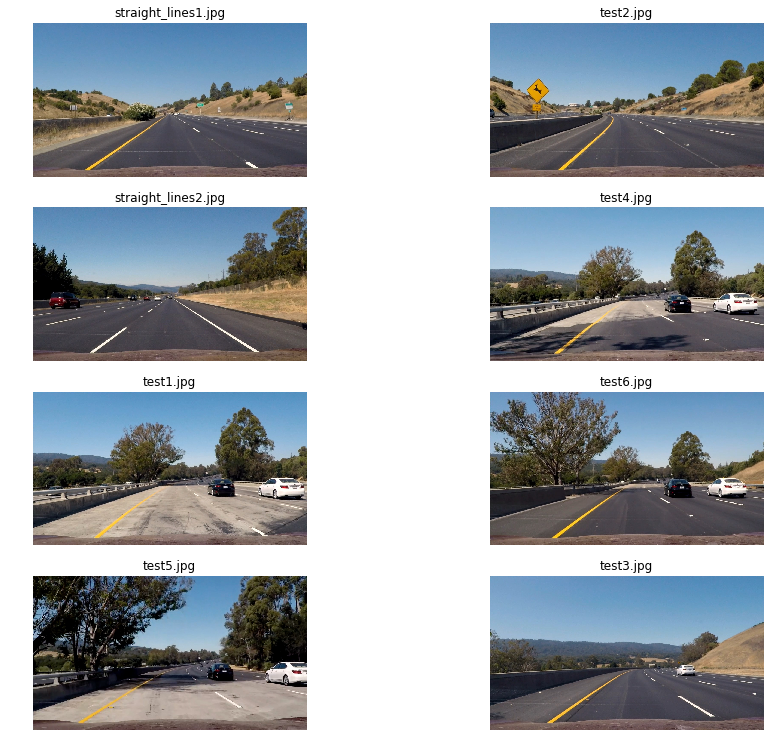

In [5]:
import glob

# create list of image arrays 
test_images = glob.glob('./test_images/*.jpg')
test_imgs_read = []

i=0
for img in test_images:
    img = mpimg.imread(img)
    test_imgs_read.append(img) 
    i+=1

# Load test images.
testImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), 
                      glob.glob('./test_images/*.jpg')))

# Display images with name 
def showImages(images, cols = 4, rows = 5, figsize=(15,10), cmap = None):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            if cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap=cmap)
            ax.set_title(imgListing[index])
            ax.axis('off')
            
            
# Plot two images side by side
def plt_images(img_1, title_1, img_2, title_2, cmap='gray'):
    # Visualize undirstorsion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(title_1, fontsize=16)
    ax1.imshow(img_1)
    ax2.set_title(title_2, fontsize=16)
    ax2.imshow(img_2, cmap='gray')
        
showImages(list(map(lambda img: (img[0], cv2.cvtColor(img[1], cv2.COLOR_BGR2RGB)),testImages)), 2, 4, (15, 13))

## Constants for Transformations

In [6]:
#ESTABLISH FUNCTION CONSTANTS

#GAUSSIAN BLUR PARAMETERS
KERNEL_SIZE = 3

#CANNY EDGE DETECTION PARAMETERS
LOW_THRESHOLD = 75 
HIGH_THRESHOLD = 150 

#REGION OF INTEREST PARAMETERS
H_CONST = 0.08
RIGHT_LANE_SLOPE = 14/32
RIGHT_LANE_CONST = 400
TOP_OFFSET_H = 40 
TOP_OFFSET_V = 40

#HOUGH LINES PARAMETERS
RHO = 3.5 
THETA = np.pi/180
MIN_VOTES = 30    
MIN_LINE_LEN = 5 
MAX_LINE_GAP= 25  
LOWER_EDGE = 800

#CHESSBOARD CORNER PARAMETERS 
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y


# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension


## Calibration 

### Distortion Correction

In [7]:
import pickle 
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Use calibration image to retreive object and image points given 
# the number of corners per row and column. 

nx = 9
ny = 6

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

fnames = glob.glob("camera_cal/calibration*.jpg")

sample_img = mpimg.imread('camera_cal/calibration3.jpg')
img_shape = sample_img.shape


for fname in fnames:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
# use the object and image points to caliberate the camera and compute the camera matrix and distortion coefficients
ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape[:2],None,None)



### Aerial View Transformation 

In [8]:
# AERIAL VIEW 
def warp(img):
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])
    
    src_coordinates = np.float32(
    [[280,  700],  # Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right

    dst_coordinates = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right  
    
    # testing different set of src and dst points 
#     src_coordinates = np.float32(
#     [[280,  700],  # Bottom left
#      [595,  460],  # Top left
#      [725,  460],  # Top right
#      [1125, 700]]) # Bottom right

#     dst_coordinates = np.float32(
#     [[320, 720],  # Bottom left
#      [320, 0],  # Top left
#      [960, 0],  # Top right
#      [960, 720]]) # Bottom right  


    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)

    
    # Compute the inverse perspective transfor also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst_coordinates, src_coordinates)
    
    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv




#### Calibration Test Unit

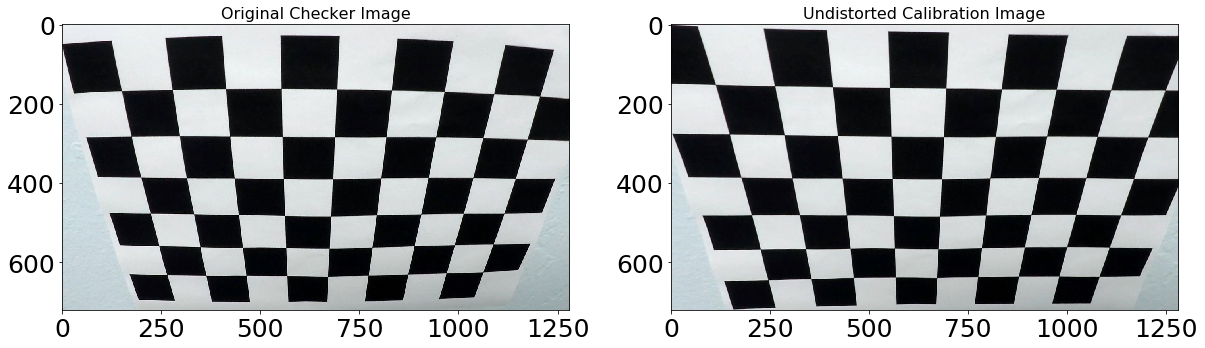

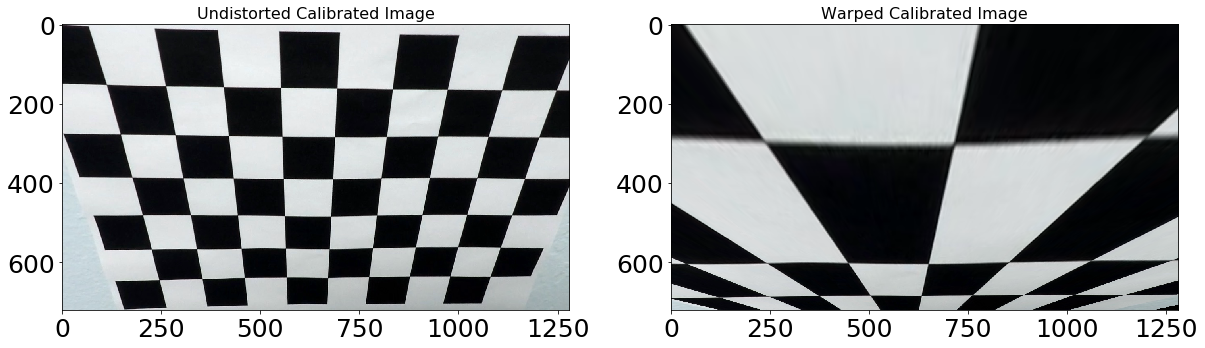

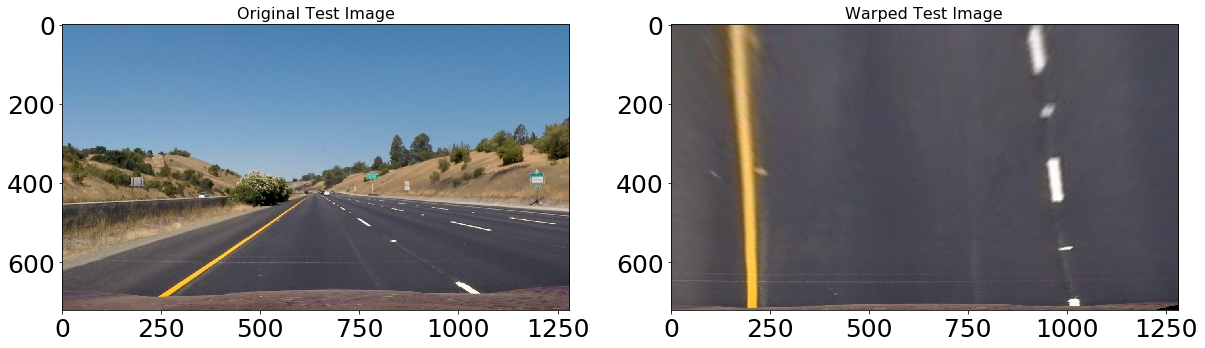

In [9]:
import matplotlib

matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25)


img = cv2.imread('./camera_cal/calibration2.jpg')
undistorted_img = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
warped_checker_img, M, Minv = warp(undistorted_img)
warped_img,  M, Minv = warp(test_imgs_read[0])


plt_images(img, 'Original Checker Image', undistorted_img, 'Undistorted Calibration Image', cmap='gray')
plt_images(undistorted_img, 'Undistorted Calibrated Image', warped_checker_img, 'Warped Calibrated Image', cmap='gray')
plt_images(test_imgs_read[0], 'Original Test Image', warped_img, 'Warped Test Image', cmap='gray')



## Colorspace and Feature Helper Functions 


In [10]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    
def convert_to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)    

def color_mask(hsv,low,high):
    # Takes in low and high values and returns mask
    mask = cv2.inRange(hsv, low, high)
    return mask

def blur(image):
    blur_image = cv2.GaussianBlur(image, (3,3),0)
    return blur_image

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def get_vertices(img):
    #get image parameters for extracting the region of interest
    img_height = img.shape[0]
    img_width = img.shape[1]

    left_lane_bot = (img_width/9 - H_CONST*img_width, img_height)
    left_lane_top = (img_width / 2 - (TOP_OFFSET_H ), img_height / 2 + TOP_OFFSET_V)
    right_lane_top = (img_width /2 + TOP_OFFSET_H, img_height/2 + TOP_OFFSET_V)
    right_lane_bot = (img_width - (RIGHT_LANE_SLOPE*img_width-RIGHT_LANE_CONST) + 
                         (H_CONST*img_width), img_height)
    
    vertices = np.array([[left_lane_bot, left_lane_top, right_lane_top, right_lane_bot]], dtype=np.int32)
                        
    return vertices

def region_of_interest(img, vertices):
    """
    Will black out any pixel outside the polygonal region of interest. The ch
    """
    
    mask = np.copy(img) * 0 #creating a blank mask
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

### Gradient Thresholding Functions

#### Gradient and Color Function Test Unit

In [11]:
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    max_value = np.max(abs_sobel)
    binary_output = np.uint8(255*abs_sobel/max_value)
    threshold_mask = np.zeros_like(binary_output)
    threshold_mask[(binary_output >= thresh_min) & (binary_output <= thresh_max)] = 1
    return threshold_mask

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mask

def combined_thresholds(img):
    
    img = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
    
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    height, width = gray.shape
    
    # apply gradient threshold on the horizontal gradient
    sx_binary = abs_sobel_thresh(gray, 'x', 10, 200)
    
    # apply gradient direction threshold to detect edges closest to vertical orientation.
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    
    # combine the gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (150, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 10)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) | (s_condition | combined_condition)] = 1
    
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    return thresholded
    
    
    

### Color Threshold Testing 


Text(0.5,1,'R and G Threshold')

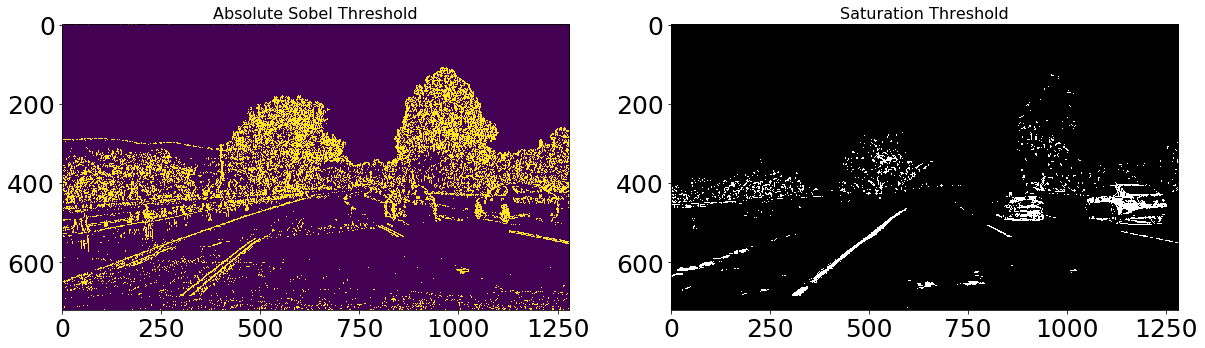

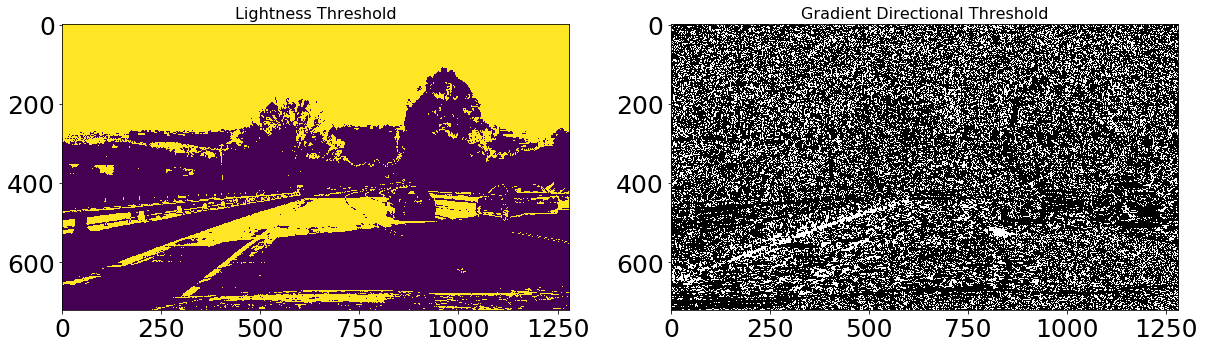

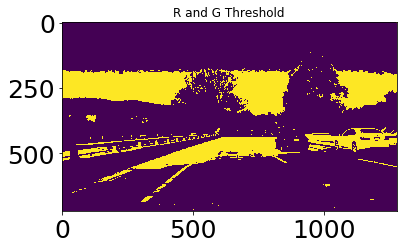

In [17]:
hls = cv2.cvtColor(test_imgs_read[3], cv2.COLOR_RGB2HLS)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

gray = cv2.cvtColor(test_imgs_read[3], cv2.COLOR_RGB2GRAY)

# Sobel Grdadient Threhsold in x-orientation
sx_binary = abs_sobel_thresh(gray, 'x', 10, 200)

# Directional gradient Threshold close to vertical 
dir_thresh=(0.9, 1.3)
# Calculate the x and y gradients
sobel_kernel=15
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
# Take the absolute value of the gradient direction, 
absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

# apply a threshold, and create a binary image result
dir_binary =  np.zeros_like(absgraddir)
dir_binary[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1


# Threshold color channel
color_threshold = 150
R = test_imgs_read[3][:,:,0]
G = test_imgs_read[3][:,:,1]
rg_combined = np.zeros_like(R)
r_g_condition = (R > color_threshold) & (G > color_threshold)
rg_combined[r_g_condition] = 1

s_thresh = (150, 255)
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1


l_thresh = (120, 200)
l_binary = np.zeros_like(l_channel)
l_binary[(l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

# Stack each channel
s_combined = np.dstack(( np.zeros_like(sx_binary), sx_binary, s_binary)) * 255

plt_images(sx_binary, "Absolute Sobel Threshold", s_binary, "Saturation Threshold")
plt_images(l_binary, "Lightness Threshold", dir_binary, "Gradient Directional Threshold")


plt.figure()
plt.imshow(rg_combined)
plt.title('R and G Threshold')

### Thresholded Peak Detection 

In [18]:
import matplotlib

def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    return histogram



### Histogram test unit

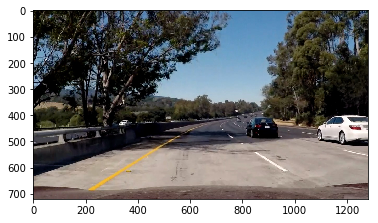

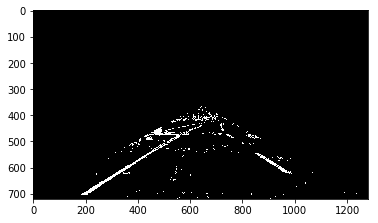

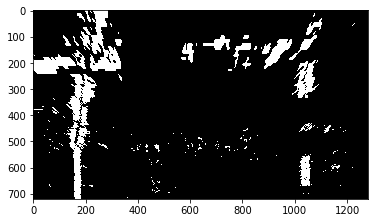

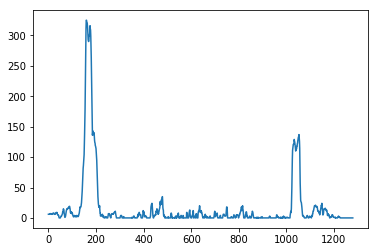

In [19]:

matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)

test_img = test_imgs_read[6]

plt.figure()
plt.imshow(test_img)
combined_threshold_img = combined_thresholds(test_img)
plt.figure()
plt.imshow(combined_threshold_img, cmap='gray')

combined_warped_img,  M, Minv  = warp(combined_threshold_img)

plt.figure()
plt.imshow(combined_warped_img, cmap='gray')
plt.figure()
plt.plot(hist(combined_warped_img))



### Test Binary Color Threshold Filter 

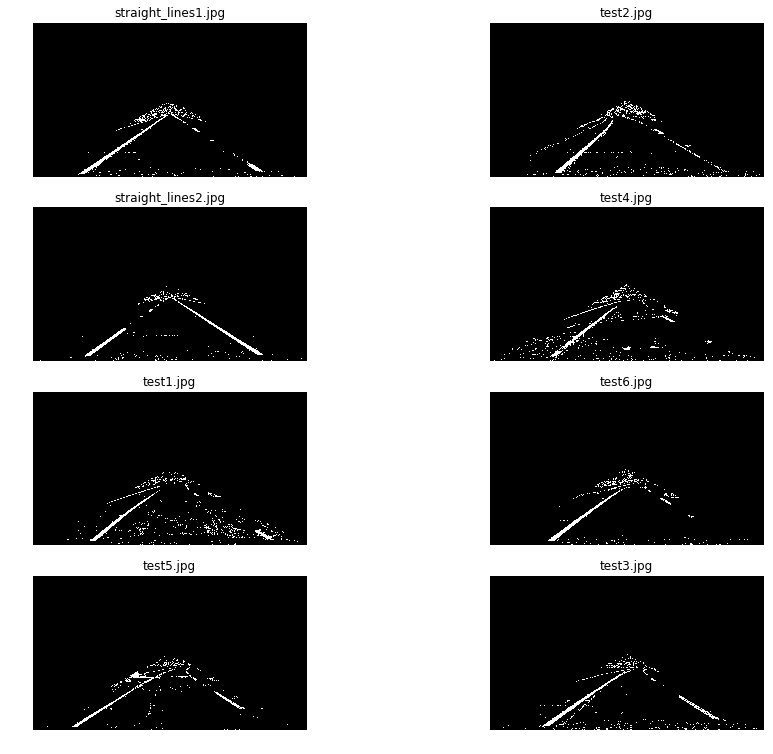

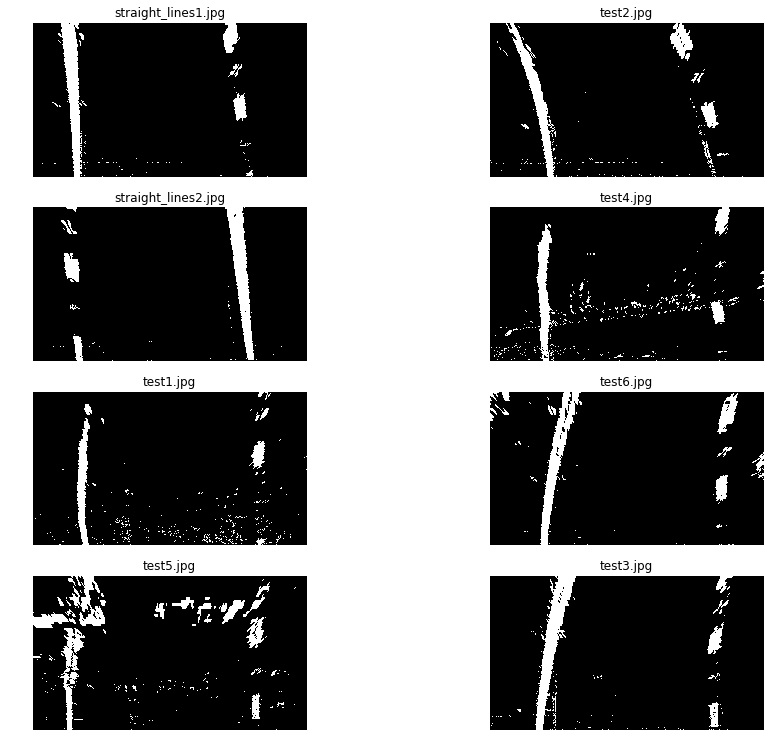

In [20]:
def applyAndPack(images, action):
    """
    Images is a colletion of pairs (`title`, image). This function applies `action` to the image part of `images`
    and pack the pair again to form (`title`, `action`(image)).
    """
    return list(map(lambda img: (img[0], action(img[1])), images))

def applyAndShow(images, action, cmap='gray'):
    """
    Applies `action` to the pair collection `images` (`title`, image) show the images and titles and return
    (`title`, `action`(image))
    """
    output = applyAndPack(images, action)
    showImages( output, 2, 4, (15, 13), cmap=cmap)
    return output

results_CombinedThreshold = applyAndShow(testImages, combined_thresholds)

combineAndTransform = lambda img: warp(combined_thresholds(img))[0]
resultPerspective = applyAndShow(testImages, combineAndTransform, cmap='gray')

# list(map(lambda img: (img[0], action(img[1])), images))
# results_WarpedThresh = applyAndShow(resultsCombined, warp)

In [21]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


#Identify peaks of histogram where non-zero pixels are generally detected lanes. 
#These will be the starting point for the left and right lines

def find_lane_pixels(binary_warped):
    
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = binary_warped[binary_warped.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    #get x and y values for all nonzero (activated) pixels
    nonzero = binary_warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Initialize lane pixel array. This will store all the non-zero pixels found within the sliding windows. 
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    out_img[np.where((out_img==[255,255,255]).all(axis=2))] = [0, 0, 0]


    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    return left_fitx, right_fitx, left_fit_m, right_fit_m 

left_fitx, right_fitx, left_fit_m, right_fit_m = find_lane_pixels(combined_warped_img)





In [22]:
def curvature_radius (leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit new polynomials to x,y in world space
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad


left_curverad, right_curverad = curvature_radius(left_fitx, right_fitx, img_shape, xm_per_pix, ym_per_pix)

print('Left line curvature:', left_curverad, 'm')
print('Right line curvature:', right_curverad, 'm')

Left line curvature: 701.575042541 m
Right line curvature: 12386.2409955 m


In [23]:
#draw polynomial lines relative to driver's center 
def car_offset(left_fitx, right_fitx, img_shape, xm_per_pix=3.7/800):
    ## Image mid horizontal position 
    mid_imgx = img_shape[1]//2
        
    ## Car position with respect to the lane
    car_pos = (left_fitx[-1] + right_fitx[-1])/2
    
    ## Horizontal car offset 
    offsetx = (mid_imgx - car_pos) * xm_per_pix

    return offsetx


def fill_lane(img, warped_img, left_fitx, right_fitx, Minv):
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0] )


    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    
    return result
 




### Preliminary Main Pipeleline Testing 

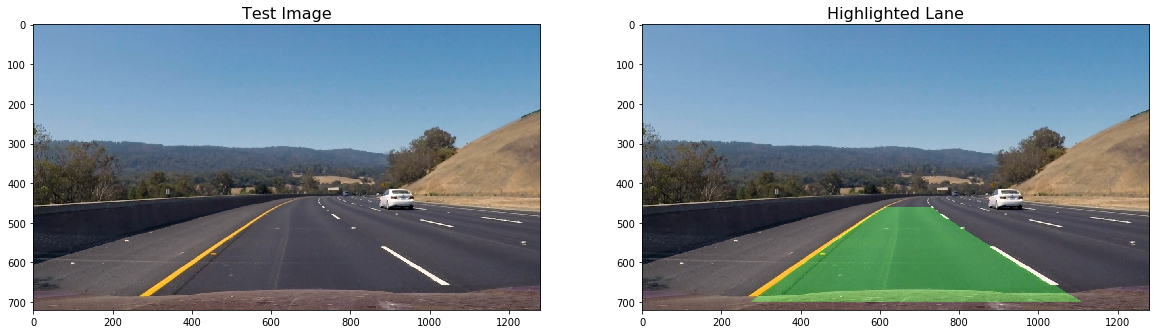

In [24]:
test_img = test_imgs_read[7]
combined_threshold_img = combined_thresholds(test_img)
combined_warped_img,  M, Minv = warp(combined_threshold_img)
left_fitx, right_fitx, left_fit_m, right_fit_m  = find_lane_pixels(combined_warped_img )
filled_lane_img = fill_lane(test_img, combined_warped_img, left_fitx, right_fitx, Minv)


plt_images(test_img, 'Test Image', filled_lane_img, 'Highlighted Lane')



## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [25]:
#FINAL PIPELINE

def process_image(img):
    combined_threshold_img = combined_thresholds(img)
    combined_warped_img,  M, Minv = warp(combined_threshold_img)
    left_fitx, right_fitx, left_fit_m, right_fit_m  = find_lane_pixels(combined_warped_img )
    result = fill_lane(img, combined_warped_img, left_fitx, right_fitx, Minv)

    curvature_rads = curvature_radius(left_fitx, right_fitx, img.shape,
                                      xm_per_pix, ym_per_pix)
    # Calculate car offset
    offsetx = car_offset(left_fitx, right_fitx, img.shape)

    # Display lane curvature readings
    cv2.putText(result, 'Left lane line curvature: {:.2f} m'.format(curvature_rads[0]), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(result, 'Right lane line curvature: {:.2f} m'.format(curvature_rads[1]), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    # Display car offset
    cv2.putText(result, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    
    return result

In [26]:
def load_images(image_type):
    if image_type == 'test':
        glob_regex = 'test_images/*.jpg'
    else:
        print('Invalid Type')
        return
    images=[]
    for f in glob.glob(glob_regex):
  
        img=mpimg.imread(f)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append((f,img))
        
    return images


def view_all_transforms(images):
    n = len(images)
    
    def view_single_transform(i):
        file, img = images[i]
        
        final_img = process_image(img)
            
        # Visualize transformation
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img, cmap='gray')
        ax1.set_title(imgListing[i], fontsize=30)
        ax2.imshow(final_img)
        ax2.set_title('Final Image', fontsize=30)
        
    interact(view_single_transform, i=(0,n-1)) #create transformed image slider 

In [27]:
# DISPLAY PROCESSED TEST IMAGES 
images_test = load_images('test')
# view_all_transforms(images_test)

view_all_transforms(testImages)




interactive(children=(IntSlider(value=3, description='i', max=7), Output()), _dom_classes=('widget-interact',))

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from moviepy.editor import VideoFileClip


In [29]:
def calibrate_camera(images, nx=9, ny=6):
  
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    img = None
    for fname in images:    
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # Camera calibration, given object points, image points, and the shape of the grayscale image
    if (len(objpoints) > 0):
        # Camera successfully calibrated.
        print("Camera successfully calibrated.")
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    else:
        # Unable to calibrate the camera.
        print("Unable to calibrate the camera.")
        ret, mtx, dist, rvecs, tvecs = (None, None, None, None, None)

    return ret, mtx, dist, rvecs, tvecs



In [30]:
class ProcessImage:
    def __init__(self, images):
        # Make a list of calibration images
        images = glob.glob(images)
        
        nx = 9
        ny = 6

        objpoints = []
        imgpoints = []

        objp = np.zeros((nx*ny,3), np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

        fnames = glob.glob("camera_cal/calibration*.jpg")

        sample_img = mpimg.imread('camera_cal/calibration3.jpg')
        img_shape = sample_img.shape


        for fname in fnames:
            img = mpimg.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
            if ret:
                objpoints.append(objp)
                imgpoints.append(corners)
        
        # use the object and image points to caliberate the camera and compute the camera matrix and distortion coefficients
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape[:2],None,None)

        
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = calibrate_camera(images)
        self.lines_fit = None

    def __call__(self, img):
        
        
        # Undistord image
        img = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)

        combined_threshold_img = combined_thresholds(img)
        
        combined_warped_img,  M, Minv  = warp(combined_threshold_img)
        
        left_fitx, right_fitx, left_fit_m, right_fit_m  = find_lane_pixels(combined_warped_img )
        
        result = fill_lane(img, combined_warped_img, left_fitx, right_fitx, Minv)
        
        
        curvature_rads = curvature_radius(left_fitx, right_fitx, img.shape,
                                      xm_per_pix, ym_per_pix)
        # Calculate car offset
        offsetx = car_offset(left_fitx, right_fitx, img.shape)

        # Display lane curvature
        cv2.putText(result, 'Left lane line curvature: {:.2f} m'.format(curvature_rads[0]), 
                    (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
        cv2.putText(result, 'Right lane line curvature: {:.2f} m'.format(curvature_rads[1]), 
                    (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)

        # Display car offset
        cv2.putText(result, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
                    (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)

            
        return result

In [31]:
input_video = './project_video.mp4'
output_video = './project_video_solution.mp4'

## You may uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip(input_video).subclip(0,4)
# clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
process_image = ProcessImage('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

Camera successfully calibrated.
[MoviePy] >>>> Building video ./project_video_solution.mp4
[MoviePy] Writing video ./project_video_solution.mp4


 99%|█████████▉| 100/101 [00:29<00:00,  3.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_solution.mp4 

CPU times: user 20 s, sys: 3.02 s, total: 23.1 s
Wall time: 33 s


Let's try the one with the solid white lane on the right first ...

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [33]:
challenge_output = 'output_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('challenge_video.mp4').subclip(0,5)
# clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video output_challenge_video.mp4
[MoviePy] Writing video output_challenge_video.mp4


100%|██████████| 150/150 [00:46<00:00,  2.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_challenge_video.mp4 

CPU times: user 29.7 s, sys: 5.38 s, total: 35.1 s
Wall time: 50.4 s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))